# torch.distributed.nn.all_to_all Scaling

In [25]:
# Set up notebook
import os
import pathlib
import glob
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

from datetime import datetime

font = {
        'family' : 'sans',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

import matplotlib.font_manager
# matplotlib.font_manager.fontManager.ttflist

In [7]:
class All2All:
    def __init__(self,path,gpu_list):
        self.base_path = path
        self.gpu_list = gpu_list
        self.n_gpu = len(gpu_list)
        self.all2all = np.zeros((self.n_gpu,))
        self.counts = np.zeros((self.n_gpu,))
        self.scaling_ideal = np.zeros((self.n_gpu,))
        self.scaling_efficiency = np.zeros((self.n_gpu,))
        
    def get_value(self,string):
        return float(string.split(":")[1].strip().split(' ')[0])
    
    def parse_files(self):
        for i in range(self.n_gpu):
            path = self.base_path+f"/{self.gpu_list[i]}/all2all.*"
            # Loop over runs found
            run_files = glob.glob(path)
            for run_file in run_files:
                print('Reading file: ', run_file)
                with open(run_file,'r') as fh:
                    for l in fh:
                        if "Average all2all time" in l:
                            self.all2all[i] += self.get_value(l)
                            self.counts[i] += 1

        # Divide by the counts for each gpu number to get the average over runs
        np.divide(self.all2all, self.counts, out=self.all2all, where=self.counts>0)
           
        # Compute the scaling efficiency
        #single_node = self.train_fom['throughput_epoch_par'][3]
        #self.scaling_ideal = np.array([self.gpu_list[3+i]/self.gpu_list[3]*single_node for i in range(len(self.gpu_list[3:]))])
        #self.scaling_efficiency = 100*self.train_fom['throughput_epoch_par'][3:]/self.scaling_ideal

## Load All Data

In [8]:
top_dir = "/Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/all2all_bench/"

In [18]:
#### Aurora
case_dir = "aurora/all2all"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 6, 24, 96]
aurora_a2a = All2All(dir_path,gpu_list)
aurora_a2a.parse_files()

case_dir = "aurora/all2all_opt"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 6, 24, 96]
aurora_a2ao = All2All(dir_path,gpu_list)
aurora_a2ao.parse_files()

#### Frontier
case_dir = "frontier/all2all"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 4, 16, 64]
frontier_a2a = All2All(dir_path,gpu_list)
frontier_a2a.parse_files()

case_dir = "frontier/all2all_opt"
dir_path = top_dir + case_dir
gpu_list = [0.5, 1, 4, 16, 64]
frontier_a2ao = All2All(dir_path,gpu_list)
frontier_a2ao.parse_files()




Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/all2all_bench/aurora/all2all/0.5/all2all.o729672
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/all2all_bench/aurora/all2all/1/all2all.o729672
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/all2all_bench/aurora/all2all/6/all2all.o729672
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/all2all_bench/aurora/all2all/24/all2all.o729681
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/all2all_bench/aurora/all2all/96/all2all.o729682
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/all2all_bench/aurora/all2all_opt/0.5/all2all.o729672
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/all2all_bench/aurora/all2all_opt/1/all2all.o729672
Reading file:  /Users/rbalin/Documents/Research/ALCF/Nek/GNN/NekRS-ML/all2all_bench/aurora/all2all_opt/6/all2all.o729672
Reading file:  /Users/rbalin/Documents/Researc

## Plot Scaling

Text(0, 0.5, 'Time [sec]')

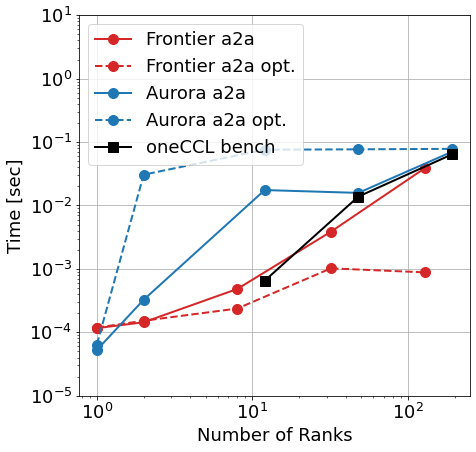

In [30]:
# Average parallel training throughput, based on epoch time

frontier_gpu_list = [0.5, 1, 4, 16, 64]
frontier_rank_list = [i*2 for i in frontier_gpu_list]
aurora_gpu_list = [0.5, 1, 6, 24, 96]
aurora_rank_list = [i*2 for i in aurora_gpu_list]

ccl_bench_rank_list = [12, 12*4, 12*16]
ccl_bench_1MB_topo = [650*1e-6, 13785.35*1e-6, 63798.40*1e-6]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
axs.plot(frontier_rank_list, frontier_a2a.all2all,label = "Frontier a2a",marker="o",ls="-",markersize=10,linewidth=2,color='tab:red')
axs.plot(frontier_rank_list, frontier_a2ao.all2all,label = "Frontier a2a opt.",marker="o",ls="--",markersize=10,linewidth=2,color='tab:red')

axs.plot(aurora_rank_list, aurora_a2a.all2all,label = "Aurora a2a",marker="o",ls="-",markersize=10,linewidth=2,color='tab:blue')
axs.plot(aurora_rank_list, aurora_a2ao.all2all,label = "Aurora a2a opt.",marker="o",ls="--",markersize=10,linewidth=2,color='tab:blue')

axs.plot(ccl_bench_rank_list, ccl_bench_1MB_topo, label = "oneCCL bench",marker="s",ls="-",markersize=10,linewidth=2,color='k')

axs.set_xscale("log")
axs.grid()
axs.set_xlabel('Number of Ranks')

       
axs.set_yscale("log")
axs.set_ylim(1e-5,1e1)
axs.legend(loc='upper left')
axs.set_ylabel('Time [sec]')
#fig.savefig("frontier_NekRS-ML_scaling.pdf", format="pdf")